# I’m Something of a Painter Myself

# Problem Description

This notebook is for the Kaggle competition "I'm Something of a Painter Myself" found at this [link](https://www.kaggle.com/competitions/gan-getting-started). The competition challenges us to use a Generative Adversarial Network or GAN, to create images in the style of Monet. The concept here is actually really simple, essentially a GAN consists of a painter in this case, and an art critic determining if the painting is a Monet. The painter creates the image, gets the feedback from the critic, and uses it to improve. The critic guesses if it's a Monet, and tries to improve its guesses. 

In the actual implementation, this will be 2 models, one being the generative model (the painter), and the other being the discriminator model (the critic).

As mentioned in the competition overview, the task here will be to build a GAN that generates 7,000 to 10,000 Monet-style images.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
from tensorflow.keras import layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         # print(os.path.join(dirname, filename))

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)
print("Using strategy:", strategy)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

E0000 00:00:1745450367.749095      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1745450385.053603      10 service.cc:148] XLA service 0x57e222e6f300 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745450385.053646      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1745450385.053650      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1745450385.053653      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1745450385.053656      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1745450385.053659      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1745450385.053661      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1745450385.053664      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1745450385.053667      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data Description

## Reference for Getting Started

Since this Kaggle competition is a little more involved when it comes to loading in the data, I'm going to use the tutorial at the link below:

[https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial](http://)

## Loading the Data

Following the tutorial, we will keep the photo and Monet dataset separate. This is because the generative model will only need the Monets to train off of, where as the discriminator will need both datasets.

We will be working with TFRecord files, which is TensorFlow’s efficient way to store large datasets.

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/gan-getting-started


Monet TFRecord Files: 5
Photo TFRecord Files: 20


From the competition's data page we know our datasets consist of:

- monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
- monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
- photo_jpg - 7028 photos sized 256x256 in JPEG format
- photo_tfrec - 7028 photos sized 256x256 in TFRecord format

Following the tutorial again, the below code is used for creating the functions decode_image and read_tfrecord.

decode_image is used for:
- Decoding the RGB images (obviously) so it can be fed to the model efficiently.
- Normalizing the normal RGB scale of 0, 255 for each color to -1, 1 so we have a better and more consistent range.
- Reshaping the images to [256, 256, 3] so we know they'll all have the correct dimensions.

read_tfrecord will be used to read TFRecord files and create a stream of examples in the next step.

In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Now we define a function to extract the images.

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Now we can get an exmaple photo and Monet painting using the functions we created.

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

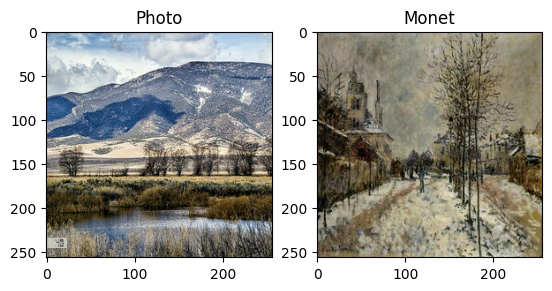

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

Now let's start taking a closer look at the data and building a model.

# Exploratory Data Analysis

First lets look at some more Monet paintings and photos so we can see some more examples.

In [9]:
data_dir = "/kaggle/input/gan-getting-started/monet_tfrec"
monet_tfrec_filenames = tf.io.gfile.glob(os.path.join(data_dir, "*.tfrec"))

data_dir_photos = "/kaggle/input/gan-getting-started/photo_tfrec"
photo_tfrec_filenames = tf.io.gfile.glob(os.path.join(data_dir_photos, "*.tfrec"))

In [10]:
print(monet_tfrec_filenames[0])
print(photo_tfrec_filenames[0])

/kaggle/input/gan-getting-started/monet_tfrec/monet12-60.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo12-352.tfrec


In [11]:
def display_images(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(dataset.take(num_images)):
        image = (image + 1.0) / 2.0
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy())
        plt.axis('off')
    plt.show()

Monet


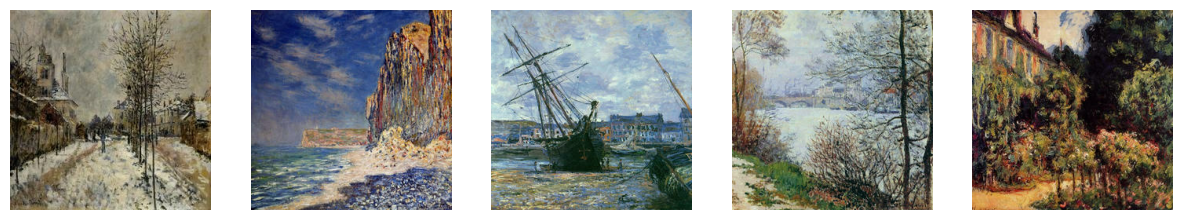

Photos


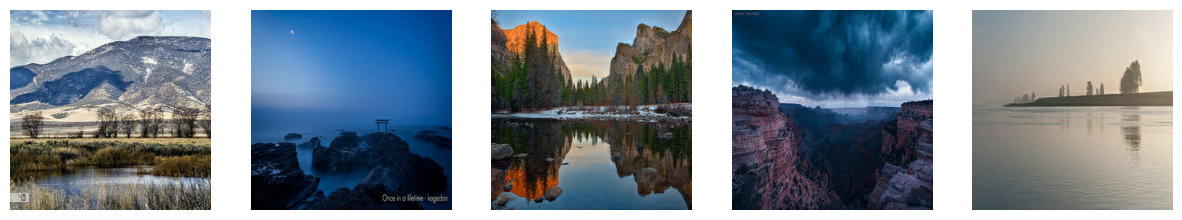

In [12]:
print("Monet")
train_dataset_monet = load_dataset(monet_tfrec_filenames)
display_images(train_dataset_monet)

print("Photos")
train_dataset_photos = load_dataset(photo_tfrec_filenames)
display_images(train_dataset_photos)

Now let's look at the number of photos and the number of Monet paintings.

In [13]:
monet_dir = "/kaggle/input/gan-getting-started/monet_jpg"  # adjust this if needed
photo_dir = "/kaggle/input/gan-getting-started/photo_jpg"

In [14]:
num_monet = len([f for f in os.listdir(monet_dir) if f.endswith(".jpg")])
num_photo = len([f for f in os.listdir(photo_dir) if f.endswith(".jpg")])

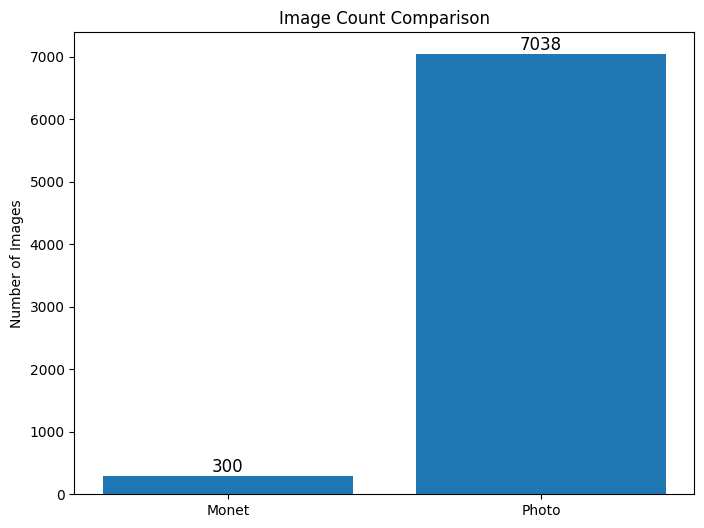

In [15]:
labels = ["Monet", "Photo"]
counts = [num_monet, num_photo]
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
             ha='center', va='bottom', fontsize=12)

plt.title("Image Count Comparison")
plt.ylabel("Number of Images")
plt.show()

We can see we have am lot more photos than Monet paintings.

# Model Building

### Instance Normalization

Prior to making the code for downsampling, I was having problems importing TensorFlow Addons because its development ended and it isn't compatible with the latest versions of Keras and TensorFlow. To fix this I just implemented a simple InstanceNormalization class that works the exact same was as tfa.layers.InstanceNormalization() but without dependency on TensorFlow addons.

Reference:
[github.com/tensorflow/addons/blob/v0.20.0/tensorflow_addons/layers/normalizations.py](http://)

In [16]:
## Custom instance normalization (replaces tfa.layers.InstanceNormalization)
class InstanceNormalization(tf.keras.layers.Layer):
    ## Initializes the base class with a very small epsilon so we don't get division by zero errors when normalizing
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    ## Called once to define and init the weights depending on input shape
    def build(self, input_shape):
        self.scale = self.add_weight(
            name="scale", shape=input_shape[-1:], initializer="ones", trainable=True
        )
        self.offset = self.add_weight(
            name="offset", shape=input_shape[-1:], initializer="zeros", trainable=True
        )
    ## Performs computation for normalization
    def call(self, x):
        ## Compute Mean and Variance for each image and channel
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        ## Scales and shifts the result (normalizes the image)
        return self.scale * (x - mean) / tf.sqrt(variance + self.epsilon) + self.offset

### Downsampling

Now, we will need to create a function for downsampling. The reason we need downsampling is to compress the input image into a smaller representation that will help us exract high-level features from the images. It will essentially help us capture the "essence" of a Monet painting while reducing computational complexity.

In [17]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(InstanceNormalization())

    result.add(layers.LeakyReLU())

    return result

Now let's test that this function is working correctly. I'm going to create a fake image and a downsampling layer, then pass the image through the downsampling layer and print the output shape. Since strides = 2 above, we should expect the new image to be 128x128, and have 64 channels created.


In [18]:
test_input = tf.random.normal([1, 256, 256, 3])
layer = downsample(64, 4)
output = layer(test_input)
print(output.shape)

(1, 128, 128, 64)


### Upsampling

Next we will need to implement an upsampling function. After downsampling, this function will reconstruct the image into its original size but now with the style transformation applied.

We can also use the InstanceNormalization class we created again to assist in implementing this function.

In [19]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
        )
    )

    result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

To test, we will do the exact same thing we did with the downsampling but this time give it a 128x128 image with 64 channels, like we would get after downsampling.

In [20]:
test_input = tf.random.normal([1, 128, 128, 64])
# 3 = output channels since the image should be RGB
layer = upsample(3, 4)
output = layer(test_input)
print(output.shape)

(1, 256, 256, 3)


### Building the Generator

Now that we have our upsampling and downsampling functions created, we can start actually creating our generator. As mentioned above the generator will act as the painter and be responsible for creating the Monet-like images.

In [21]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])  # Input image

    # Here we are essentially encoding the photo into a compact feature map
    # By the end, the image is encoded as a 1x1x512 vector
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),                           # (bs, 64, 64, 128)
        downsample(256, 4),                           # (bs, 32, 32, 256)
        downsample(512, 4),                           # (bs, 16, 16, 512)
        downsample(512, 4),                           # (bs, 8, 8, 512)
        downsample(512, 4),                           # (bs, 4, 4, 512)
        downsample(512, 4),                           # (bs, 2, 2, 512)
        downsample(512, 4),                           # (bs, 1, 1, 512)
    ]

    # Here we do the exact same thing but for upsampling, until we have our full size image again
    up_stack = [
        upsample(512, 4, apply_dropout=True),         # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),         # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),         # (bs, 8, 8, 1024)
        upsample(512, 4),                             # (bs, 16, 16, 1024)
        upsample(256, 4),                             # (bs, 32, 32, 512)
        upsample(128, 4),                             # (bs, 64, 64, 256)
        upsample(64, 4),                              # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    # Converts the final upsampled output to 3 channels for RGB
    last = tf.keras.layers.Conv2DTranspose(
        3, 4, strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='tanh'
    )

    x = inputs
    skips = []

    # Loops through each layer in the down_stack. applies the layer to our image tensor, and saves the output to feature maps
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Loops through the upsampling layers the saved skips, increases resolution, and combines the style info with our image structure info.
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

And we can test the generator below in the same way we tested the up and downsampling.

In [22]:
generator = Generator()
test_input = tf.random.normal([1, 256, 256, 3])
test_output = generator(test_input)
print(test_output.shape)

(1, 256, 256, 3)


### Building the Discriminator

Now we can build the discriminator which will be acting as the "critic", described above, and deciding whether or not to classify the image as a Monet painting or a fake one generated by our model.

In [23]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp
    
    down1 = downsample(64, 4, apply_instancenorm=False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    # The pads essentially allow our discrimminator to analyze the image based on its parts and ask how real does each section look.
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)

    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer, use_bias=False
    )(zero_pad1)

    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1, kernel_initializer=initializer
    )(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

We can test this to see if it works by creating an instance of the discriminator and passing a fake image into it.

In [24]:
disc = Discriminator()
# Input: a real or generated 256x256 image
test_input = tf.random.normal([1, 256, 256, 3])
test_output = disc(test_input)
print(test_output.shape)

(1, 30, 30, 1)


We see it did work and processed the image into 30x30 patches (900 total) and gave it a score between 0 and 1 based on realness.

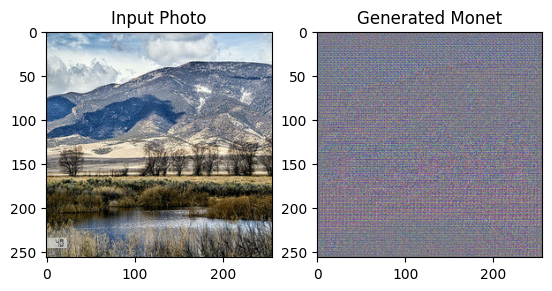

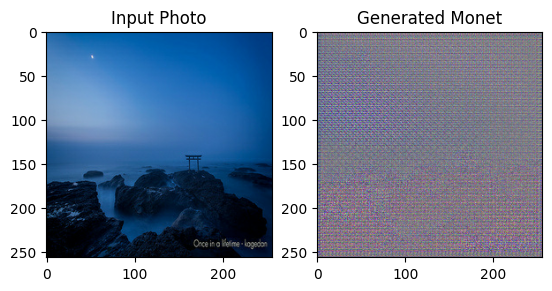

In [25]:
for i, img in enumerate(photo_ds.take(2)):
    generated = generator(img, training=False)[0].numpy()
    real = img[0].numpy()

    # Undo normalization from [-1,1] to [0,255]
    generated = (generated * 127.5 + 127.5).astype(np.uint8)
    real = (real * 127.5 + 127.5).astype(np.uint8)

    plt.subplot(1, 2, 1)
    plt.title("Input Photo")
    plt.imshow(real)

    plt.subplot(1, 2, 2)
    plt.title("Generated Monet")
    plt.imshow(generated)

    plt.show()

### Building the CycleGAN Class

Now we can build the CycleGAN class. The class will be a subclass of tf.keras.Model that combines the two generators and two discriminators. It will essentially be facilitating the training by defining logic for forward passes and loss calculations, and handling the specific training steps with the train_step function. Since it's a subclass of tf.keras.Model, we can still use .fit like we have been for models in other projects.

In [26]:
class CycleGan(tf.keras.Model):
    def __init__(self, gen_G, gen_F, disc_X, disc_Y, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.gen_G = gen_G  # Photo -> Monet
        self.gen_F = gen_F  # Monet -> Photo
        self.disc_X = disc_X  # Discriminator for photos
        self.disc_Y = disc_Y  # Discriminator for Monet paintings
        self.lambda_cycle = lambda_cycle

    def compile(self, gen_G_optimizer, gen_F_optimizer,
                disc_X_optimizer, disc_Y_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data  # real_x = photo, real_y = Monet

        with tf.GradientTape(persistent=True) as tape:
            # Generator G (photo -> Monet)
            fake_y = self.gen_G(real_x, training=True)
            cycled_x = self.gen_F(fake_y, training=True)

            # Generator F (Monet -> photo)
            fake_x = self.gen_F(real_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator predictions
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Calculate losses
            gen_G_loss = self.gen_loss_fn(disc_fake_y)
            gen_F_loss = self.gen_loss_fn(disc_fake_x)

            total_cycle_loss = self.cycle_loss_fn(real_x, cycled_x, self.lambda_cycle) + \
                               self.cycle_loss_fn(real_y, cycled_y, self.lambda_cycle)

            total_gen_G_loss = gen_G_loss + total_cycle_loss + self.identity_loss_fn(real_y, same_y, self.lambda_cycle)
            total_gen_F_loss = gen_F_loss + total_cycle_loss + self.identity_loss_fn(real_x, same_x, self.lambda_cycle)

            disc_X_loss = self.disc_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.disc_loss_fn(disc_real_y, disc_fake_y)

        # Apply gradients
        grads_G = tape.gradient(total_gen_G_loss, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_gen_F_loss, self.gen_F.trainable_variables)

        grads_disc_X = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        grads_disc_Y = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        self.gen_G_optimizer.apply_gradients(zip(grads_G, self.gen_G.trainable_variables))
        self.gen_F_optimizer.apply_gradients(zip(grads_F, self.gen_F.trainable_variables))
        self.disc_X_optimizer.apply_gradients(zip(grads_disc_X, self.disc_X.trainable_variables))
        self.disc_Y_optimizer.apply_gradients(zip(grads_disc_Y, self.disc_Y.trainable_variables))

        return {
            "gen_G_loss": total_gen_G_loss,
            "gen_F_loss": total_gen_F_loss,
            "disc_X_loss": disc_X_loss,
            "disc_Y_loss": disc_Y_loss
        }

### Building the Loss Functions

Below we've created 4 loss functions for the generators and discriminators to use. The discriminator loss helps to train the discriminators to separate real from fake Monet paintings or photos, and is therefore used by both discriminators we will initialize later. 

The next 3 are used exclusively by the generators. The generator loss penalizes the generator if it is unable to fool the corresponding discriminator. The cycle loss is used by the generators to keep the input and output conssitent through translation. Finally, the identity_loss makes sure we don't change things unneccesarily - so for example, a Monet painting passed to the Monet generator shouldn't be changed.

In [27]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
        return 0.5 * (real_loss + generated_loss)

with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

with strategy.scope():
    def cycle_loss(real_image, cycled_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return lambda_cycle * loss

with strategy.scope():
    def identity_loss(real_image, same_image, lambda_cycle):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return lambda_cycle * 0.5 * loss

### Compile and Train the Model

Now we can compile the model before training it.

We initialized 2 generators and 2 discriminators, defined optimizers for each of them with a learning rate and beta, and we built the CycleGAN using the class we created.

In [28]:
with strategy.scope():
    gen_G = Generator()  # Photo > Monet
    gen_F = Generator()  # Monet > Photo
    disc_X = Discriminator()  # Photo Discriminator
    disc_Y = Discriminator()  # Monet Discriminator

# Optimizers
with strategy.scope():
    g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    dx_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    dy_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Compile
with strategy.scope():
    cycle_gan = CycleGan(gen_G, gen_F, disc_X, disc_Y)
    cycle_gan.compile(
        gen_G_optimizer=g_optimizer,
        gen_F_optimizer=f_optimizer,
        disc_X_optimizer=dx_optimizer,
        disc_Y_optimizer=dy_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=cycle_loss,
        identity_loss_fn=identity_loss
    )

cycle_gan.build(input_shape=[ (None,256,256,3), (None,256,256,3) ])

I0000 00:00:1745450393.541938      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [31]:
# Assuming monet_ds and photo_ds are your TF Datasets with images only
train_dataset = tf.data.Dataset.zip((photo_ds, monet_ds))

# Start training
cycle_gan.fit(train_dataset, epochs=10)

Epoch 1/10


I0000 00:00:1745450610.951468      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9322864233972706018
I0000 00:00:1745450617.952383     889 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6649006826458318064), session_name()
I0000 00:00:1745450688.706898     889 tpu_compile_op_common.cc:245] Compilation of 6649006826458318064 with session name  took 1m10.754458171s and succeeded
I0000 00:00:1745450688.871189     889 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6649006826458318064), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_9322864233972706018", property.function_library_fingerprint = 13813309986309360007, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

    300/Unknown 182s 133ms/step - disc_X_loss: 0.0820 - disc_Y_loss: 0.0778 - gen_F_loss: 4.4861 - gen_G_loss: 4.4794

/usr/local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 182s 133ms/step - disc_X_loss: 0.0820 - disc_Y_loss: 0.0779 - gen_F_loss: 4.4823 - gen_G_loss: 4.4748
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - disc_X_loss: 0.0720 - disc_Y_loss: 0.0609 - gen_F_loss: 2.8282 - gen_G_loss: 2.8609
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - disc_X_loss: 0.0687 - disc_Y_loss: 0.0594 - gen_F_loss: 2.5912 - gen_G_loss: 2.6147
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - disc_X_loss: 0.0649 - disc_Y_loss: 0.0606 - gen_F_loss: 2.4104 - gen_G_loss: 2.4024
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - disc_X_loss: 0.0618 - disc_Y_loss: 0.0609 - gen_F_loss: 2.2314 - gen_G_loss: 2.2052
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - disc_X_loss: 0.0586 - disc_Y_loss: 0.0582 - gen_F_loss: 2.1033 - gen_G_loss: 2.0700
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - disc_X_loss: 0.0566 - disc_Y_loss: 0.0598 - gen_F_loss: 2.0290 - gen_G_loss: 1.9769
Epoch 8/10
300/300 ━━━━

# Results and Analysis

Now lets take a look at some of the images our generator made and compare them to the original photos.

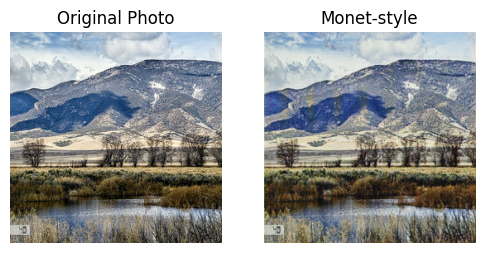

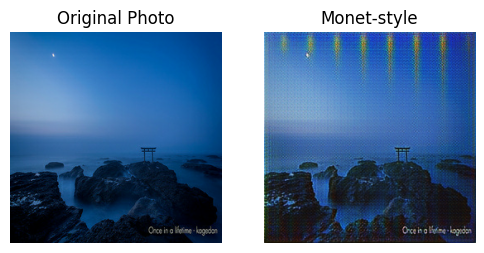

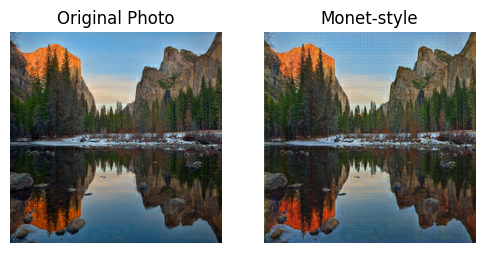

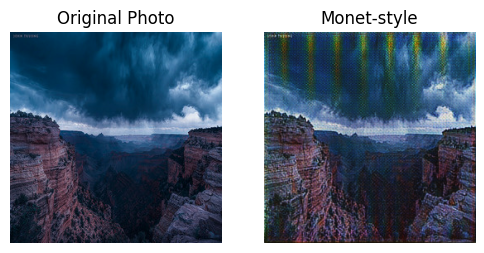

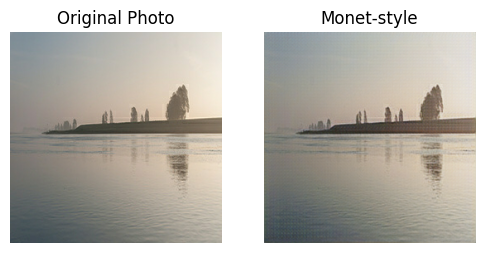

In [32]:
for image in photo_ds.take(5):
    generated = gen_G(image, training=False)[0]
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow((image[0] + 1) / 2)
    plt.title("Original Photo")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow((generated + 1) / 2)
    plt.title("Monet-style")
    plt.axis("off")
    plt.show()

Overall I would say these look great. You can see what the model is trying to do as it makes the photos in the style of Monet and can see things like brush strokes being added. There are some details, like the orange at the top of the first and second paintings that maybe we can improve with more training, however, I would say overall this did really well.

# Conclusion

In conclusion we created discrimminators and generators, a Cycle GAN model, defined loss functions, and used our model to turn photos into images that look like Monet paintings. 

The model performed pretty well from a visual inspection and we can get an exact score after we submit this assignment.

If we wanted to improve this model I think we could increase the number of epochs or maybe fine tune things like the learning rate in our model and compare the results.

# Create Submission

In [33]:
import PIL
! mkdir ../images

In [35]:
i = 1
for img in photo_ds:
    prediction = gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [36]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

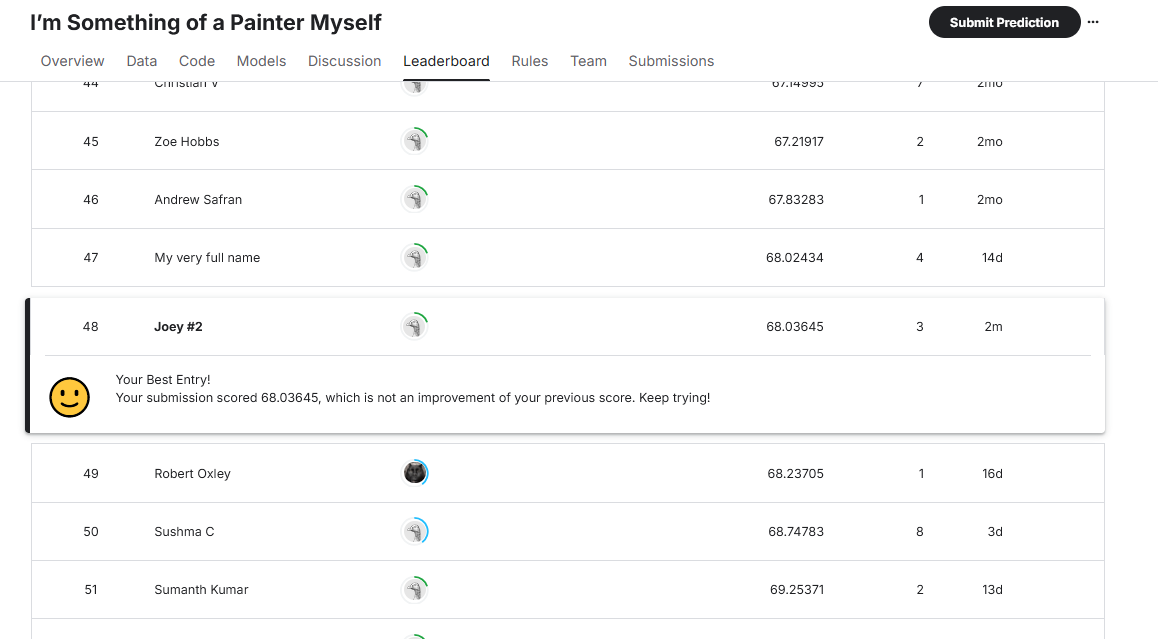

Judging by the submission we did pretty well